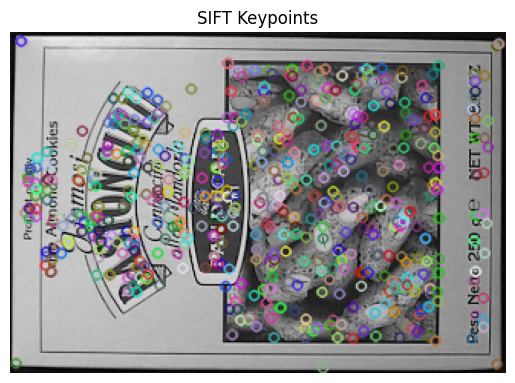

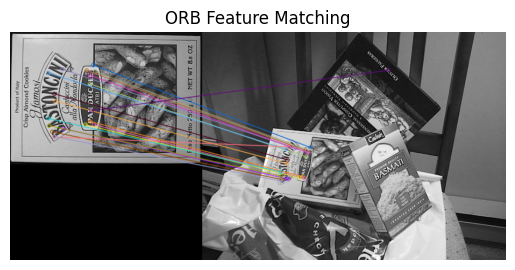

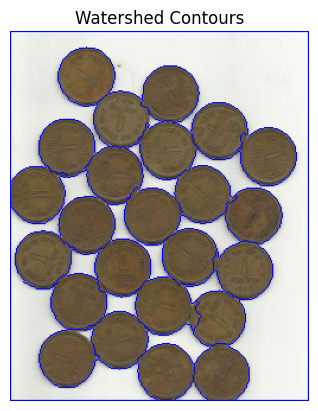

In [19]:
# Task 1: Interest Point Detection, Feature Matching, Contour Detection

import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load sample images
img1 = cv.imread(cv.samples.findFile('box.png'), cv.IMREAD_GRAYSCALE)
img2 = cv.imread(cv.samples.findFile('box_in_scene.png'), cv.IMREAD_GRAYSCALE)

# -------- Interest Point Detection with SIFT --------
sift = cv.SIFT_create()
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)

img_sift = cv.drawKeypoints(img1, kp1, None)
plt.imshow(img_sift), plt.title('SIFT Keypoints'), plt.axis('off')
plt.show()

# -------- Feature Matching with ORB and BFMatcher --------
orb = cv.ORB_create()
kp3, des3 = orb.detectAndCompute(img1, None)
kp4, des4 = orb.detectAndCompute(img2, None)

bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
matches = bf.match(des3, des4)
matches = sorted(matches, key=lambda x: x.distance)

img_match = cv.drawMatches(img1, kp3, img2, kp4, matches[:20], None, flags=2)
plt.imshow(img_match), plt.title('ORB Feature Matching'), plt.axis('off')
plt.show()

# -------- Contour Detection with Watershed --------
img = cv.imread(cv.samples.findFile('coins.jpg'))
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
ret, thresh = cv.threshold(gray, 0, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3), np.uint8)
opening = cv.morphologyEx(thresh, cv.MORPH_OPEN, kernel, iterations=2)

# Background and foreground
sure_bg = cv.dilate(opening, kernel, iterations=3)
dist_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
ret, sure_fg = cv.threshold(dist_transform, 0.7 * dist_transform.max(), 255, 0)

sure_fg = np.uint8(sure_fg)
unknown = cv.subtract(sure_bg, sure_fg)

# Marker labeling
ret, markers = cv.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown == 255] = 0

# Apply watershed
markers = cv.watershed(img, markers)
img[markers == -1] = [255, 0, 0]  # Red boundaries

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
plt.title("Watershed Contours"), plt.axis("off")
plt.show()

In [18]:
# Task 2.1 - ResNet18 and ResNet34 on CIFAR-100 with accuracy improvements

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Data preparation with augmentation
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))
])

trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

# Utility: Evaluation function
def evaluate(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    return 100. * correct / total

# Training loop
def train_model(model, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        acc = evaluate(model, testloader)
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Test Accuracy: {acc:.2f}%")

# Load ResNet18 and ResNet34 with adjusted final layer
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ResNet18
resnet18 = models.resnet18(pretrained=True)
resnet18.fc = nn.Linear(resnet18.fc.in_features, 100)
resnet18.to(device)
optimizer18 = torch.optim.SGD(resnet18.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
print("\nTraining ResNet18...")
train_model(resnet18, optimizer18)

# ResNet34
resnet34 = models.resnet34(pretrained=True)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 100)
resnet34.to(device)
optimizer34 = torch.optim.SGD(resnet34.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
print("\nTraining ResNet34...")
train_model(resnet34, optimizer34)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 203MB/s]


Training ResNet18...


Epoch 1, Loss: 2.8592, Test Accuracy: 40.11%
Epoch 2, Loss: 2.4948, Test Accuracy: 41.09%
Epoch 3, Loss: 2.1607, Test Accuracy: 45.11%
Epoch 4, Loss: 2.0119, Test Accuracy: 46.53%
Epoch 5, Loss: 1.8916, Test Accuracy: 47.80%
Epoch 6, Loss: 1.7983, Test Accuracy: 49.36%
Epoch 7, Loss: 1.7151, Test Accuracy: 51.97%
Epoch 8, Loss: 1.6471, Test Accuracy: 50.81%
Epoch 9, Loss: 1.5874, Test Accuracy: 52.29%
Epoch 10, Loss: 1.5312, Test Accuracy: 53.47%
Epoch 11, Loss: 1.4863, Test Accuracy: 50.89%
Epoch 12, Loss: 1.4259, Test Accuracy: 51.35%
Epoch 13, Loss: 1.3897, Test Accuracy: 53.69%
Epoch 14, Loss: 1.3488, Test Accuracy: 54.51%
Epoch 15, Loss: 1.3223, Test Accuracy: 52.76%
Epoch 16, Loss: 1.2762, Test Accuracy: 53.73%
Epoch 17, Loss: 1.2335, Test Accuracy: 52.74%
Epoch 18, Loss: 1.2080, Test Accuracy: 55.14%
Epoch 19, Loss: 1.1866, Test Accuracy: 55.12%
Epoch 20, Loss: 1.1572, Test Accuracy: 54.83%


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 185MB/s]



Training ResNet34...
Epoch 1, Loss: 2.7744, Test Accuracy: 42.09%
Epoch 2, Loss: 2.3770, Test Accuracy: 44.73%
Epoch 3, Loss: 2.0133, Test Accuracy: 47.26%
Epoch 4, Loss: 1.8346, Test Accuracy: 48.28%
Epoch 5, Loss: 1.7060, Test Accuracy: 49.60%
Epoch 6, Loss: 1.6078, Test Accuracy: 52.65%
Epoch 7, Loss: 1.5262, Test Accuracy: 54.33%
Epoch 8, Loss: 1.4650, Test Accuracy: 54.15%
Epoch 9, Loss: 1.3813, Test Accuracy: 55.17%
Epoch 10, Loss: 1.3461, Test Accuracy: 54.89%
Epoch 11, Loss: 1.2844, Test Accuracy: 56.43%
Epoch 12, Loss: 1.2397, Test Accuracy: 56.31%
Epoch 13, Loss: 1.1901, Test Accuracy: 56.42%
Epoch 14, Loss: 1.1498, Test Accuracy: 54.82%
Epoch 15, Loss: 1.1215, Test Accuracy: 56.43%
Epoch 16, Loss: 1.0798, Test Accuracy: 56.34%
Epoch 17, Loss: 1.0532, Test Accuracy: 57.29%
Epoch 18, Loss: 1.0152, Test Accuracy: 56.63%
Epoch 19, Loss: 0.9947, Test Accuracy: 56.88%
Epoch 20, Loss: 0.9459, Test Accuracy: 56.13%


In [6]:
# Install required libraries (if not already)
!pip install -q elasticdeform torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 7.1 MB/s eta 0:00:00


[ProtoNet] Episode 0, Loss: 2.5370
[ProtoNet] Episode 5, Loss: 9.4002
[ProtoNet] Episode 10, Loss: 3.5405
[ProtoNet] Episode 15, Loss: 0.2695
[ProtoNet] Episode 20, Loss: 3.0649
[ProtoNet] Episode 25, Loss: 5.5695
[Siamese] Epoch 1, Loss: 3.1368
[Siamese] Epoch 2, Loss: 0.1403
[Siamese] Epoch 3, Loss: 0.1088
[Siamese] Epoch 4, Loss: 0.0855
[Siamese] Epoch 5, Loss: 0.0569
[Siamese] Epoch 6, Loss: 0.0375
[Siamese] Epoch 7, Loss: 0.0271
[Siamese] Epoch 8, Loss: 0.0226
[Siamese] Epoch 9, Loss: 0.0202
[Siamese] Epoch 10, Loss: 0.0181

--- Evaluating Siamese ---
Sample 1/30 - True: 0, Pred: 0, Match: ✅
Sample 2/30 - True: 0, Pred: 0, Match: ✅
Sample 3/30 - True: 0, Pred: 0, Match: ✅
Sample 4/30 - True: 1, Pred: 1, Match: ✅
Sample 5/30 - True: 1, Pred: 1, Match: ✅
Sample 6/30 - True: 1, Pred: 1, Match: ✅
Sample 7/30 - True: 2, Pred: 2, Match: ✅
Sample 8/30 - True: 2, Pred: 2, Match: ✅
Sample 9/30 - True: 2, Pred: 2, Match: ✅
Sample 10/30 - True: 3, Pred: 3, Match: ✅
Sample 11/30 - True: 3, Pr

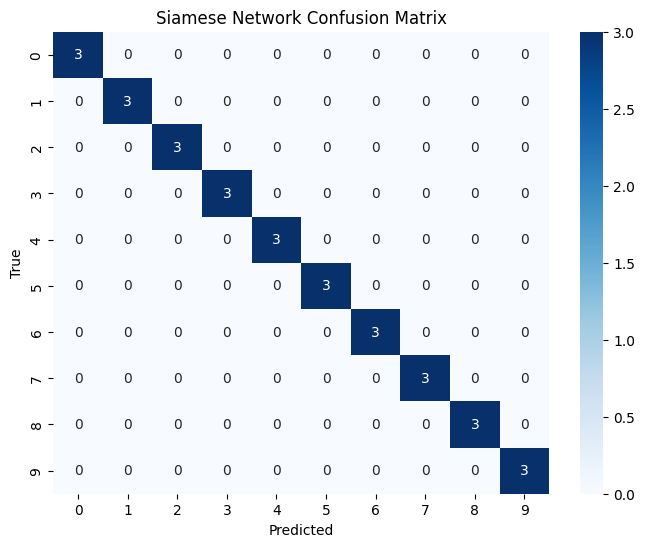


--- Evaluating Prototypical Network ---
[ProtoNet] True: 0, Pred: 0, Match: ✅
[ProtoNet] True: 0, Pred: 1, Match: ❌
[ProtoNet] True: 0, Pred: 0, Match: ✅
[ProtoNet] True: 1, Pred: 1, Match: ✅
[ProtoNet] True: 1, Pred: 1, Match: ✅
[ProtoNet] True: 1, Pred: 1, Match: ✅
[ProtoNet] True: 2, Pred: 8, Match: ❌
[ProtoNet] True: 2, Pred: 2, Match: ✅
[ProtoNet] True: 2, Pred: 6, Match: ❌
[ProtoNet] True: 3, Pred: 8, Match: ❌
[ProtoNet] True: 3, Pred: 5, Match: ❌
[ProtoNet] True: 3, Pred: 3, Match: ✅
[ProtoNet] True: 4, Pred: 8, Match: ❌
[ProtoNet] True: 4, Pred: 4, Match: ✅
[ProtoNet] True: 4, Pred: 9, Match: ❌
[ProtoNet] True: 5, Pred: 8, Match: ❌
[ProtoNet] True: 5, Pred: 8, Match: ❌
[ProtoNet] True: 5, Pred: 3, Match: ❌
[ProtoNet] True: 6, Pred: 6, Match: ✅
[ProtoNet] True: 6, Pred: 6, Match: ✅
[ProtoNet] True: 6, Pred: 6, Match: ✅
[ProtoNet] True: 7, Pred: 7, Match: ✅
[ProtoNet] True: 7, Pred: 8, Match: ❌
[ProtoNet] True: 7, Pred: 8, Match: ❌
[ProtoNet] True: 8, Pred: 8, Match: ✅
[ProtoNet

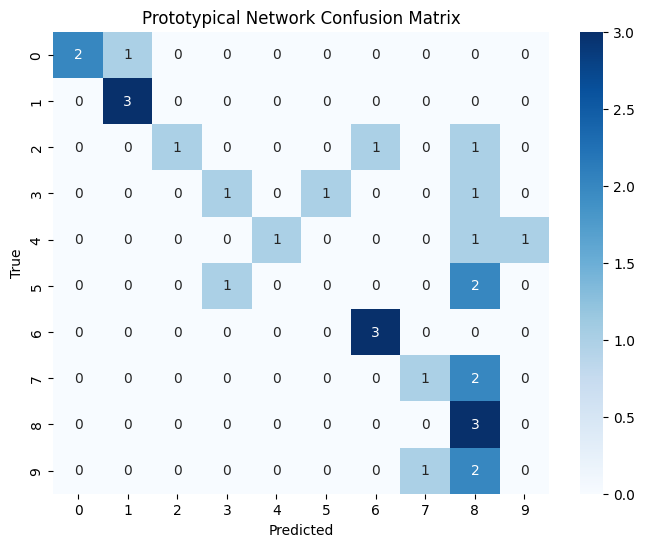


--- Evaluating Matching Network (after encoder training) ---
[ProtoNet] Episode 0, Loss: 24.4489
[ProtoNet] Episode 5, Loss: 9.6272
[ProtoNet] Episode 10, Loss: 12.9603
[ProtoNet] Episode 15, Loss: 4.2339
[ProtoNet] Episode 20, Loss: 3.8119
[ProtoNet] Episode 25, Loss: 2.5012
Sample 1/30 - True: 0, Pred: 0, Match: ✅
Sample 2/30 - True: 0, Pred: 0, Match: ✅
Sample 3/30 - True: 0, Pred: 0, Match: ✅
Sample 4/30 - True: 1, Pred: 0, Match: ❌
Sample 5/30 - True: 1, Pred: 0, Match: ❌
Sample 6/30 - True: 1, Pred: 0, Match: ❌
Sample 7/30 - True: 2, Pred: 0, Match: ❌
Sample 8/30 - True: 2, Pred: 0, Match: ❌
Sample 9/30 - True: 2, Pred: 0, Match: ❌
Sample 10/30 - True: 3, Pred: 0, Match: ❌
Sample 11/30 - True: 3, Pred: 0, Match: ❌
Sample 12/30 - True: 3, Pred: 0, Match: ❌
Sample 13/30 - True: 4, Pred: 0, Match: ❌
Sample 14/30 - True: 4, Pred: 0, Match: ❌
Sample 15/30 - True: 4, Pred: 0, Match: ❌
Sample 16/30 - True: 5, Pred: 0, Match: ❌
Sample 17/30 - True: 5, Pred: 0, Match: ❌
Sample 18/30 - Tr

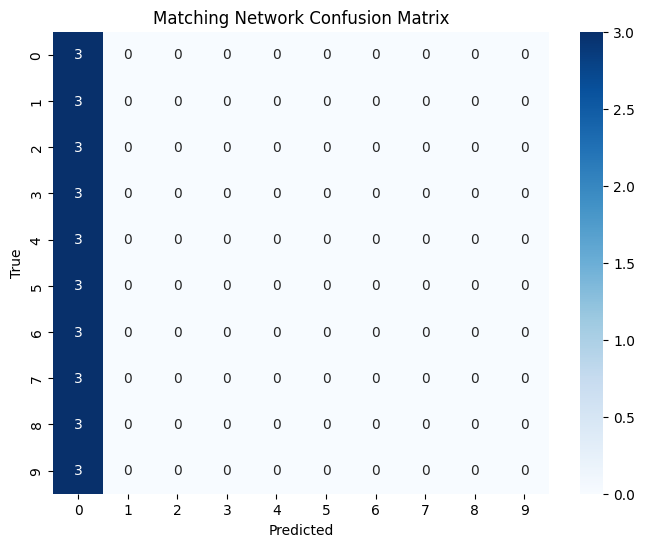

In [16]:
# Meta Learning on MNIST – Full Code

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
from scipy.ndimage import map_coordinates, gaussian_filter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Elastic deformation

def elastic_deformation(image, alpha=36, sigma=6):
    random_state = np.random.RandomState(None)
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma, mode="constant") * alpha
    x, y_coord = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y_coord + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))
    return map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)

# Load and preprocess MNIST
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.0,), (1.0,))])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
X = mnist.data.numpy()
y = mnist.targets.numpy()

X_deformed = np.array([elastic_deformation(img) for img in X[:1000]])
y_deformed = y[:1000]
X_train, X_test, y_train, y_test = X_deformed[:800], X_deformed[800:], y_deformed[:800], y_deformed[800:]

class FewShotDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_ds = FewShotDataset(X_train, y_train)

# Prototypical Network
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3), nn.ReLU(), nn.MaxPool2d(2)
        )
    def forward(self, x): return self.encoder(x).view(x.size(0), -1)

def compute_prototypes(support_embeddings, support_labels):
    classes = torch.unique(support_labels)
    return torch.stack([support_embeddings[support_labels == c].mean(0) for c in classes]), classes

def euclidean_dist(a, b): return torch.cdist(a.unsqueeze(1), b.unsqueeze(0)).squeeze()

def train_protonet(model, dataset, n_episodes=30, n_way=5, k_shot=5, q_queries=3):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    model.train()
    for episode in range(n_episodes):
        classes = random.sample(list(torch.unique(dataset.y).numpy()), n_way)
        indices = [i for i, (_, label) in enumerate(dataset) if label.item() in classes]
        loader = DataLoader(torch.utils.data.Subset(dataset, indices), batch_size=len(indices), shuffle=True)
        images, labels = next(iter(loader))

        support_idxs, query_idxs = [], []
        for c in classes:
            idx = (labels == c).nonzero(as_tuple=True)[0]
            support_idxs += idx[:k_shot].tolist()
            query_idxs += idx[k_shot:k_shot+q_queries].tolist()

        support_embeddings = model(images[support_idxs])
        query_embeddings = model(images[query_idxs])
        prototypes, class_ids = compute_prototypes(support_embeddings, labels[support_idxs])
        dists = euclidean_dist(query_embeddings, prototypes)
        targets = torch.tensor([class_ids.tolist().index(l.item()) for l in labels[query_idxs]])
        loss = F.cross_entropy(-dists, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if episode % 5 == 0:
            print(f"[ProtoNet] Episode {episode}, Loss: {loss.item():.4f}")

proto_model = ConvEncoder()
train_protonet(proto_model, train_ds)

# Siamese Network
class SiameseMNIST(Dataset):
    def __init__(self, images, labels, num_pairs=5000):
        self.images = torch.tensor(images, dtype=torch.float32).unsqueeze(1)
        self.labels = labels
        self.pairs, self.targets = [], []
        for _ in range(num_pairs):
            c = random.choice(np.unique(labels))
            i1, i2 = np.random.choice(np.where(labels == c)[0], 2, replace=False)
            self.pairs.append((self.images[i1], self.images[i2]))
            self.targets.append(1.0)
            c1, c2 = np.random.choice(np.unique(labels), 2, replace=False)
            i1 = np.random.choice(np.where(labels == c1)[0])
            i2 = np.random.choice(np.where(labels == c2)[0])
            self.pairs.append((self.images[i1], self.images[i2]))
            self.targets.append(0.0)
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx): return self.pairs[idx][0], self.pairs[idx][1], torch.tensor(self.targets[idx], dtype=torch.float32)

class SiameseNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(nn.Linear(64*5*5, 256), nn.ReLU(), nn.Linear(256, 128))
    def forward_once(self, x): return self.fc(self.cnn(x).view(x.size(0), -1))
    def forward(self, x1, x2): return self.forward_once(x1), self.forward_once(x2)

class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
    def forward(self, out1, out2, label):
        dist = F.pairwise_distance(out1, out2)
        return (label * dist**2 + (1 - label) * (self.margin - dist).clamp(min=0)**2).mean()

def train_siamese(model, loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = ContrastiveLoss()
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for img1, img2, label in loader:
            out1, out2 = model(img1, img2)
            loss = criterion(out1, out2, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"[Siamese] Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

siamese_ds = SiameseMNIST(X_train, y_train)
siamese_loader = DataLoader(siamese_ds, batch_size=32, shuffle=True)
siamese_model = SiameseNet()
train_siamese(siamese_model, siamese_loader)

def one_shot_predict(model, support_set, query_img):
    with torch.no_grad():
        query_feat = model.forward_once(query_img.unsqueeze(0))
        min_dist = float('inf')
        pred_class = -1
        for img, label in support_set:
            support_feat = model.forward_once(img.unsqueeze(0))
            dist = F.pairwise_distance(query_feat, support_feat)
            if dist.item() < min_dist:
                min_dist = dist.item()
                pred_class = label
        return pred_class

# Matching Network Encoder
class MatchingNetEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 64, 3), nn.ReLU(), nn.MaxPool2d(2)
        )
    def forward(self, x): return self.encoder(x).view(x.size(0), -1)

def cosine_similarity(query, support):
    query = F.normalize(query, p=2, dim=1)
    support = F.normalize(support, p=2, dim=1)
    return torch.matmul(query, support.T)

def matching_net_predict(model, support_images, support_labels, query_image):
    with torch.no_grad():
        support_embeddings = model(support_images)
        query_embedding = model(query_image.unsqueeze(0))
        similarities = cosine_similarity(query_embedding, support_embeddings)
        attention = F.softmax(similarities, dim=1)
        support_labels = torch.tensor(support_labels).float()
        output = torch.matmul(attention, support_labels.unsqueeze(1))
        return torch.argmax(output).item()

# Support/query set
selected_classes = np.unique(y_train)[:10]
support_set, query_set = [], []
for cls in selected_classes:
    idxs = np.where(y_train == cls)[0]
    support_img = torch.tensor(X_train[idxs[0]]).unsqueeze(0).float()
    support_set.append((support_img, cls))
    for q in range(1, 4):
        query_img = torch.tensor(X_train[idxs[q]]).unsqueeze(0).float()
        query_set.append((query_img, cls))

# Evaluation functions

def evaluate_model(model, support_set, query_set, model_type="siamese"):
    y_true, y_pred, correct = [], [], 0
    for i, (query_img, query_label) in enumerate(query_set):
        if model_type == "siamese":
            pred = one_shot_predict(model, support_set, query_img)
        else:
            support_imgs = torch.stack([img for img, _ in support_set]).float()
            support_labels = [label for _, label in support_set]
            pred = matching_net_predict(model, support_imgs, support_labels, query_img.float())
        y_true.append(query_label)
        y_pred.append(pred)
        correct += int(pred == query_label)
        print(f"Sample {i+1}/{len(query_set)} - True: {query_label}, Pred: {pred}, Match: {'✅' if pred==query_label else '❌'}")
    print(f"\nOverall Accuracy ({model_type}): {(correct/len(query_set)) * 100:.2f}%")
    return y_true, y_pred

def print_scores(y_true, y_pred, model_name):
    print(f"\n📊 {model_name} Final Evaluation")
    print(f"Accuracy:  {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall:    {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score:  {f1_score(y_true, y_pred, average='macro'):.4f}")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Evaluate all models
print("\n--- Evaluating Siamese ---")
y_true_siam, y_pred_siam = evaluate_model(siamese_model, support_set, query_set, "siamese")
print_scores(y_true_siam, y_pred_siam, "Siamese Network")

print("\n--- Evaluating Prototypical Network ---")
def evaluate_protonet(model, support_set, query_set):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        support_imgs = torch.stack([img for img, _ in support_set])
        support_labels = torch.tensor([label for _, label in support_set])
        support_embeddings = model(support_imgs)

        for query_img, query_label in query_set:
            query_embedding = model(query_img.unsqueeze(0))
            dists = euclidean_dist(query_embedding, support_embeddings)
            pred_idx = torch.argmin(dists).item()
            pred = support_labels[pred_idx].item()
            y_true.append(query_label)
            y_pred.append(pred)
            print(f"[ProtoNet] True: {query_label}, Pred: {pred}, Match: {'✅' if pred==query_label else '❌'}")

    accuracy = accuracy_score(y_true, y_pred)
    print(f"\nOverall Accuracy (protonet): {accuracy * 100:.2f}%")
    return y_true, y_pred

y_true_proto, y_pred_proto = evaluate_protonet(proto_model, support_set, query_set)
print_scores(y_true_proto, y_pred_proto, "Prototypical Network")

print("\n--- Evaluating Matching Network (after encoder training) ---")
matching_encoder = MatchingNetEncoder()
train_protonet(matching_encoder, train_ds, n_episodes=30)
y_true_match, y_pred_match = evaluate_model(matching_encoder, support_set, query_set, "matching")
print_scores(y_true_match, y_pred_match, "Matching Network")